# Anomaly Detection

Anomaly (our outlier) detection deals with the finding of data points (behaviors) that are "different" from what "expected". The terms anomaly and outlier are often used interchangeably. Anomaly/outlier detection is typically an unsupervised task and thus is highly related to cluster analysis. Clustering looks for patterns in data whereas anomaly detection aims at identifying the data points that deviate from such patterns. Accordingly, anomaly detection and clustering analysis serve different, almost orthogonal, purposes.

Anomaly detection: expect our data to have some distribution, unknown to us. For some reasons, there may be some anomalies. Anomalies may depends on some acquisition problems (e.g., faulty sensors), some user input error or, in some other cases, anomaly is not really an error but an outlier which we do not want to have in our dataset.

Sometimes, the anomalies are the goal since there are some applications in which the goal is to identify some special insights in data: this problem is called **anomaly detection**. Fraud detection is a typical example of anomaly: we have several not-fraud transactions, while some of them are not. We want to identify them. Another example, is to identify faults (e.g., in a device). We want to be able to identify in advance that something will go wrong. To do that, we might resort to anomaly detection.

 So, if we want to get rid of something then it is an outlier detections. 

In this notebook, we will check some of the most common anomaly detection techniques. For this purpose we first generate a working example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# num_outliers = 0

We generate an artificial dataset.

In [3]:
def GenerateAnomalyDetectionExample(n=1000, d=2, r=0.01, or_=10, random_state=1234):
    """n number of samples we want to generate
       d number of dimensions (2D so that we can plot it)
       r outlier ratio (generate r*n outliers)
       or_ outlier range
    """
    
    num_samples = n
    num_dimensions = d
    outlier_ratio = r
    
    # number of "usual" data points
    num_inliers = int(num_samples * (1-outlier_ratio))
    
    # number of outliers
    num_outliers = num_samples - num_inliers

    np.random.seed(random_state)
    # Generate the normally distributed inliers (mean 0, sigma 1)
    X_standard = np.random.randn(num_inliers, num_dimensions)
    
    # Add outliers sampled from a random uniform distribution
    X_outliers = np.random.uniform(low=-or_, high=or_, size=(num_outliers, num_dimensions))
    
    X = np.r_[X_standard, X_outliers]
    
    # Generate labels, 1 for inliers and −1 for outliers

    labels = np.ones(num_samples, dtype=int)
    labels[-num_outliers:]= (-1)
    
    return X, labels

In [4]:
X, labels = GenerateAnomalyDetectionExample()

## Plotting the data

Using clustering (k-Means) is not a proper way for outliers identification. This because, firstly, we do not know how many cluster we have in our data. Secondly, outliers affect k-Means. To use clustering for outlier detection, a good idea could be to use **density-based clustering**.

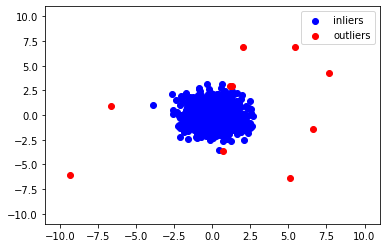

In [5]:
plt.scatter(X[labels==1,0], X[labels==1,1], c='b', label='inliers') 
plt.scatter(X[labels==-1,0], X[labels==-1,1], c='r', label='outliers') 
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.legend(numpoints=1)
plt.show()


## Single Variable Statistical Methods (Heuristical Method)
#### Description
The simplest way to identify anomalies is to analyze each variable separately using simple statistics like for example standard deviation. If we assume that the variables are normally distributed we can label as outlier the points lying outside $2\sigma$ or $3\sigma$.

#### Problems
A problem of this method is that it works on one variable at once. By considering 
Another problem is that the outliers affect significantly the mean, $\mu$, and the standard deviation, $\sigma$.

Data may be i.i.d. but only if we consider inliers.
Variables may not be independent. If this is the case,

In [6]:
for c in range(X.shape[1]):
    print("Variable X%d mean=%.3f sigma=%.3f"%(c, X[:,c].mean(), X[:,c].std()))

Variable X0 mean=0.037 sigma=1.101
Variable X1 mean=0.033 sigma=1.101


In [7]:
def PrintStdOutliers(X):
    for c in range(X.shape[1]):
        mean = X[:,c].mean()
        std = X[:,c].std()
        lower = mean - 3*std
        upper = mean + 3*std
        outliers = ((X[:,c]>upper) | (X[:,c]<lower))

        if (outliers.sum()>0):
            print("Variable X%d (%.3f,%.3f) has %d outliers"%(c,mean,std,outliers.sum()))
            print("\t===============================")
            for i,v in enumerate(X[outliers==True,c]):
                print("\t%d\t%.3f"%(i,v))
            print("\t===============================")

        else:
            print("Variable X%d has no outliers")

In [8]:
PrintStdOutliers(X)

Variable X0 (0.037,1.101) has 7 outliers
	0	-3.881
	1	5.072
	2	5.438
	3	6.610
	4	-6.687
	5	7.687
	6	-9.346
Variable X1 (0.033,1.101) has 7 outliers
	0	-3.564
	1	6.881
	2	-3.647
	3	-6.413
	4	6.916
	5	4.236
	6	-6.063


## Mean Absolute Deviation
The median absolute deviation (MAD) is an alternative to the standard deviation for finding outliers in one-dimensional data. MAD is defined as the median of the absolute deviations from the series median. We compute first the median. Then, for each point we compute the discrepancy from the point to the median.

In [9]:
from scipy import stats

stats.median_abs_deviation(X, scale='normal')

array([0.9727663 , 0.98924766])

In [10]:
def MAD(X, scale_factor = 1.4826):
    """This shows the actual implementation of MAD. The scale factor
       is an approximation and thus the result is slightly different."""
    mad = np.zeros(X.shape[1])
    for c in range(X.shape[1]):
        mad[c] = np.median(np.abs(X[:,c] - np.median(X[:,c])))
    return scale_factor*mad

In [11]:
MAD(X)

array([0.97276484, 0.98924618])

Instead of using the standard deviation values, we can use MAD values that are more robust than standard deviation with respect to the range of the outliers. Typically the lower and upper limit to define anomalies are taken by subtracting/adding 2xMAD multiplied by an adjustment coefficient to the median. For example, let's generate another dataset in which the range of the outliers is 1000.

In [12]:
X1, labels1 = GenerateAnomalyDetectionExample(n=1000, d=2, r=0.01, or_=1000)

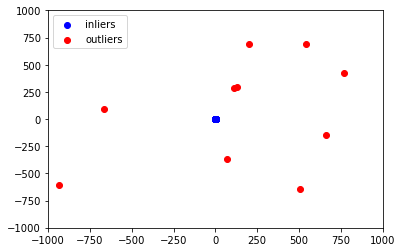

In [13]:
plt.scatter(X1[labels==1,0], X1[labels==1,1], c='b', label='inliers') 
plt.scatter(X1[labels==-1,0], X1[labels==-1,1], c='r', label='outliers') 
plt.xlim(-1001,1001)
plt.ylim(-1001,1001)
plt.legend(numpoints=1)
plt.show()

In [14]:
def PrintAnomalyLimits(X):
    mad = stats.median_abs_deviation(X, scale='normal')
    for c in range(X.shape[1]):
        mean = X[:,c].mean()
        std = X[:,c].std()
        median = np.median(X[:,c])


        lower = mean - 3*std
        upper = mean + 3*std
        mad_lower = median - 3*mad[c]
        mad_upper = median + 3*mad[c]

        print("Variable X%d (%.3f,%.3f)"%(c,mean,std))
        print("\tStandard Deviation Limits (%.3f,%.3f)"%(lower,upper))
        print("\tMAD Limits (%.3f,%.3f)"%(mad_lower,mad_upper))

In [15]:
PrintAnomalyLimits(X)

Variable X0 (0.037,1.101)
	Standard Deviation Limits (-3.267,3.341)
	MAD Limits (-2.895,2.942)
Variable X1 (0.033,1.101)
	Standard Deviation Limits (-3.270,3.337)
	MAD Limits (-2.948,2.988)


In [16]:
PrintAnomalyLimits(X1)

Variable X0 (1.409,54.537)
	Standard Deviation Limits (-162.201,165.020)
	MAD Limits (-2.895,2.942)
Variable X1 (0.749,47.371)
	Standard Deviation Limits (-141.362,142.861)
	MAD Limits (-2.948,2.988)


Thus, the limits for determining outliers using MAD are less influenced by the range of outliers as it happens when using the standard deviation.

In [17]:
PrintStdOutliers(X1)

Variable X0 (1.409,54.537) has 7 outliers
	0	200.117
	1	507.237
	2	543.814
	3	660.987
	4	-668.750
	5	768.742
	6	-934.630
Variable X1 (0.749,47.371) has 9 outliers
	0	688.116
	1	-364.721
	2	-641.337
	3	295.514
	4	691.640
	5	-143.349
	6	423.611
	7	290.468
	8	-606.319


In [18]:
def PrintMADOutliers(X, tolerance=3):
    mad = stats.median_abs_deviation(X, scale='normal')

    # the coefficient is usually twice the mad multiplied by a tolerance factor
    for c in range(X.shape[1]):
        mean = np.mean(X[:,c])
        std = np.std(X[:,c])
        median = np.median(X[:,c])
        lower = median - tolerance*mad[c]
        upper = median + tolerance*mad[c]
        outliers = ((X[:,c]>upper) | (X[:,c]<lower))

        if (outliers.sum()>0):
            print("Variable X%d (%.3f,%.3f) has %d outliers"%(c,mean,std,outliers.sum()))
            print("\t===============================")
            for i,v in enumerate(X[outliers==True,c]):
                print("\t%d\t%.3f"%(i,v))
            print("\t===============================")

        else:
            print("Variable X%d has no outliers")

In [19]:
PrintMADOutliers(X1)

Variable X0 (1.409,54.537) has 11 outliers
	0	-3.881
	1	200.117
	2	69.231
	3	507.237
	4	126.998
	5	543.814
	6	660.987
	7	-668.750
	8	768.742
	9	112.741
	10	-934.630
Variable X1 (0.749,47.371) has 13 outliers
	0	-3.564
	1	3.126
	2	3.110
	3	688.116
	4	-364.721
	5	-641.337
	6	295.514
	7	691.640
	8	-143.349
	9	89.549
	10	423.611
	11	290.468
	12	-606.319


## Multivariate Approaches - Elliptic Envelop
We can extend the previous approach to multivariate distributions. Elliptic envelope fitting can be a simple and elegant way to perform anomaly detection for normally distributed datasets. Anomalies are data points that do not conform to the expected distribution, these approaches exclude such outliers in the training data. Thus, this method is only minimally affected by the presence of anomalies in the dataset.

Try to fit a statistical distribution on our data, but not working on a variable at once but on multivariate variables. The most important parameter is the **contamination**: rate of outliers we assume to have in our data.

In [20]:
from sklearn.covariance import EllipticEnvelope

for outlier_ratio in [0.2, 0.1, 0.05, 0.01]:
    classifier = EllipticEnvelope(contamination=outlier_ratio)
    classifier.fit(X)
    y_pred = classifier.predict(X)
    num_errors = sum(y_pred != labels)
    print('Outlier Ratio %.3f\tNumber of errors: %d'%(outlier_ratio,num_errors))

Outlier Ratio 0.200	Number of errors: 190
Outlier Ratio 0.100	Number of errors: 90
Outlier Ratio 0.050	Number of errors: 40
Outlier Ratio 0.010	Number of errors: 4


## One-class Support Vector Machines
One-class SVMs detect anomalies by fitting an SVM using one single target class. The data, which is assumed to contain no anomalies, is used for training a model. This comprises decision boundaries that can be used to classify future incoming data points. Note that, SVMs are sensitive to outliers thus the training data should be cleaned and contain no anomalies. This approach is generally more suitable for novelty discovery than for anomaly detection.

Try to find the region of the feature space as far as possible from the origin that contains all the points in the training set.

In [ ]:
from sklearn import svm

for outlier_ratio in [0.2, 0.1, 0.05, 0.01]:
    # nu: how much of the points are expected to be outliers
    # the smaller, the stricter the separation so we expect only few points to be outliers
    classifier = svm.OneClassSVM(nu=0.99 * outlier_ratio + 0.01, kernel="rbf", gamma=0.1)
    classifier.fit(X)
    y_pred = classifier.predict(X)
    print('Outlier Ratio %.3f\tNumber of errors: %d'%(outlier_ratio,num_errors))

: 

## Isolation Forests
This approach identifies anomalies by computing the number of splits required to isolate a single data points; that is, how many times we need to perform splits on features in the dataset before we end up with a region that contains only the single target sample. The intuition outliers are easier to isolate with fewer splits because they usually have some feature value differences that distinguish them from the more typical data points (the inliers). 

We generate a totally number tree. Choose among the variables randomly and do a complete a random split. Then, repeat (choosing also again the variable) and do a random split. It stops in two cases:
1. We have been able to find a tree that has a single data point in each leaf
2. We have reached some pre-defined depth of the tree

Intuition: the more the point is isolated (not in a populated area of the tree) then the higher the probability to be an outlier. Indeed, there is more probability to isolate an outlier (an isolated point) than high-densely data points. Lower the depth, the higher the probability to be an outlier. We cannot rely on a single tree, since it is random. Doing this only for a single time, is not good. So, we create an Ensemble so that we have an huge amount of the tree and we average the depth of the tree on which the point is.

In [22]:
from sklearn.ensemble import IsolationForest

num_samples = 1000
for outlier_ratio in [0.2, 0.1, 0.05, 0.01]:
    rng = np.random.RandomState(99)

    classifier = IsolationForest(max_samples=num_samples, contamination=outlier_ratio, random_state=rng)
    classifier.fit(X)
    y_pred = classifier.predict(X)
    num_errors = sum(y_pred != labels) 
    print('Outlier Ratio %.3f\tNumber of errors: %d'%(outlier_ratio, num_errors))

Outlier Ratio 0.200	Number of errors: 190
Outlier Ratio 0.100	Number of errors: 90
Outlier Ratio 0.050	Number of errors: 40
Outlier Ratio 0.010	Number of errors: 4


## Local Outlier Factor
This is an anomaly score that classifies anomalies based on the local density around a sample, that. is, the concentration of other points in the immediate surrounding neighborhood. The size of the neighborhood region is defined either by a fixed distance threshold or by the closest $k$ neighboring points. LOF evaluates the isolation of a single data point with respect to its closest $k$ neighbors. The data points with a significantly lower local density than that of their closest $k$ neighbors are considered to be anomalies.

In [23]:
from sklearn.neighbors import LocalOutlierFactor

for outlier_ratio in [0.2, 0.1, 0.05, 0.01, 0.005]:
    classifier = LocalOutlierFactor(n_neighbors=100, contamination=outlier_ratio)
    y_pred = classifier.fit_predict(X)
    num_errors = sum(y_pred != labels) 
    print('Outlier Ratio %.3f\tNumber of errors: %d'%(outlier_ratio,num_errors))

Outlier Ratio 0.200	Number of errors: 190
Outlier Ratio 0.100	Number of errors: 90
Outlier Ratio 0.050	Number of errors: 40
Outlier Ratio 0.010	Number of errors: 4
Outlier Ratio 0.005	Number of errors: 5


## Comparison on Toy Datasets

Automatically created module for IPython interactive environment


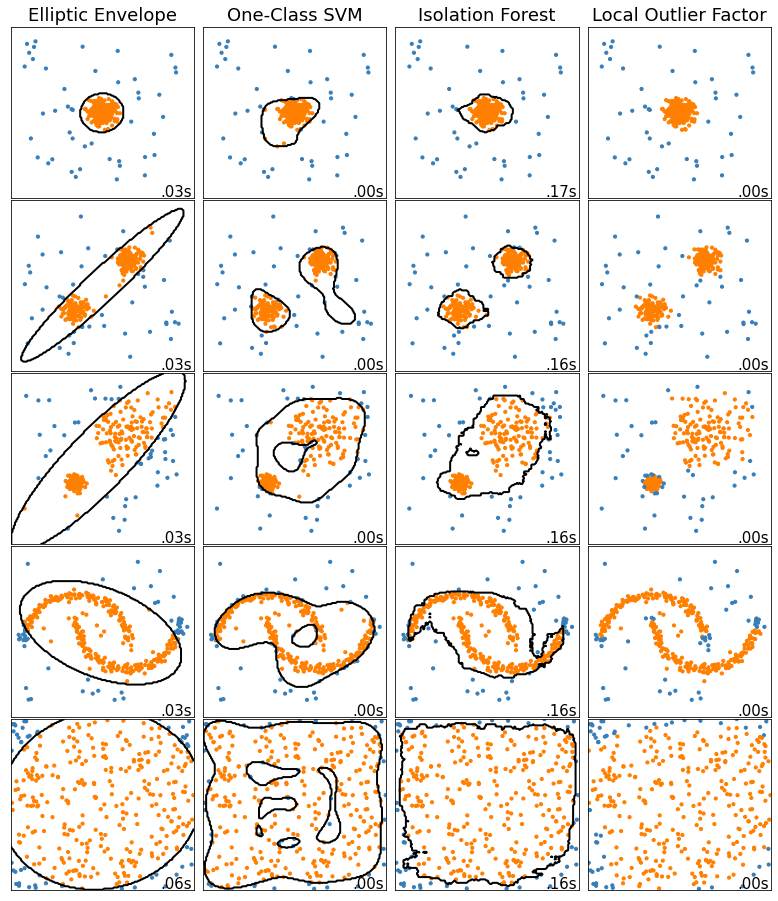

In [24]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Elliptic Envelope", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show();

* Elliptic Envelope: not work properly with multi-modal data (multiple clusters) since it assumes to have an unimodal distribution. It tries to fit an ellipse. 
* One-Class SVM: strange results because it is very sensitive to parameter choice and kernel parameters. So it is tricky to get good results with respect to the other methods

All the methods except LOF provide a model. LOF perform an analysis on each point but it does not provide us any model.